In [28]:
import numpy as np

# Camera baseline and field-of-view assumptions (example values)
baseline = 0.10              # distance between cameras (meters)
image_width, image_height = 640, 480  
HFOV = 1.047    # horizontal FOV in radians (~60 degrees)
VFOV = 0.698    # vertical FOV in radians (~40 degrees)
focal_length = (image_width/2) / np.tan(HFOV/2)

In [29]:
import cv2

def setup_cameras(left_id=0, right_id=1, width=640, height=480):
    """Initialize two camera streams (left and right) with given IDs and resolution."""
    capL = cv2.VideoCapture(left_id)
    capR = cv2.VideoCapture(right_id)
    # Set resolution
    capL.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    capL.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    capR.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    capR.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    return capL, capR

# Example calibration parameters (baseline, FOV, focal length)
baseline = 0.10  # meters
image_width, image_height = 640, 480
HFOV, VFOV = 1.047, 0.698  # radians (~60°, ~40°)
focal_length = (image_width/2) / np.tan(HFOV/2)

In [30]:
def capture_stereo_frame(capL, capR):
    """Capture a frame from left and right cameras."""
    retL, frameL = capL.read()
    retR, frameR = capR.read()
    if not retL or not retR:
        return None, None
    return frameL, frameR

# Initialize cameras
url_cam1 = "http://192.168.0.102:4747/video"
url_cam2 = "http://192.168.0.102:4747/video"
local_cam = 0  # Local camera index (usually 0 for the default camera)
cap_left, cap_right = setup_cameras(url_cam1, local_cam, image_width, image_height)


In [31]:
from ultralytics import YOLO

# Load a CPU-based YOLOv8 model (e.g., nano or small)
model = YOLO('yolov8n.pt')   # yolov8n is small; ensure CPU use
model.to('cpu')      # move to CPU
model.fuse()         # fuse layers (in place)

# Now model is ready for inference on CPU


def detect_objects(frame, model):
    """
    Run YOLO detection on a frame. Return list of detections as (cx, cy, class_id, confidence).
    """
    results = model(frame)[0]  # get first (and only) image results
    detections = []
    for box in results.boxes:
        x1, y1, x2, y2 = box.xyxy.cpu().numpy()[0]  # bounding box corners
        cls = int(box.cls.cpu().numpy()[0])
        conf = float(box.conf.cpu().numpy()[0])
        cx = (x1 + x2) / 2.0
        cy = (y1 + y2) / 2.0
        detections.append((cx, cy, cls, conf))
    return detections

# Example usage inside capture loop (illustrative, not running here):
frame_left, frame_right = capture_stereo_frame(cap_left, cap_right)
det_left = detect_objects(frame_left, model)
det_right = detect_objects(frame_right, model)


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


0: 480x640 (no detections), 242.6ms
Speed: 12.7ms preprocess, 242.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 242.6ms
Speed: 12.7ms preprocess, 242.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 219.1ms
Speed: 4.7ms preprocess, 219.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
0: 480x640 1 person, 219.1ms
Speed: 4.7ms preprocess, 219.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


In [32]:
def match_detections(det_left, det_right):
    """Match detections by class and proximity. Returns list of matched pairs ((cxL,cyL),(cxR,cyR))."""
    matched = []
    used = set()
    for (cxL, cyL, clsL, confL) in det_left:
        best = None; min_dist = float('inf')
        for j, (cxR, cyR, clsR, confR) in enumerate(det_right):
            if j in used or clsL != clsR:
                continue
            dist = abs(cyL - cyR) + abs(cxL - cxR)
            if dist < min_dist:
                min_dist = dist
                best = j
        if best is not None:
            matched.append(((cxL, cyL), (det_right[best][0], det_right[best][1])))
            used.add(best)
    return matched

# Example: after detection
pairs = match_detections(det_left, det_right) # comment below lines
for ((uL,vL),(uR,vR)) in pairs:
    # compute angles and disparity next
    angleL = (uL - image_width / 2) / focal_length
    angleR = (uR - image_width / 2) / focal_length
    disparity = uL - uR
    depth = (baseline * focal_length) / disparity if disparity != 0 else float('inf')
    print(f"Left: ({uL}, {vL}), Right: ({uR}, {vR}), "
          f"AngleL: {angleL:.2f}, AngleR: {angleR:.2f}, "
          f"Disparity: {disparity:.2f}, Depth: {depth:.2f} m")
    


In [33]:
def compute_3d(uL, vL, uR, vR, baseline, focal_length):
    """
    Given matched pixel centers (uL,vL) and (uR,vR) from left/right images, 
    compute 3D coordinates relative to left camera.
    """
    # Compute angles
    theta_h = -HFOV/2 + HFOV * (uL / image_width)
    theta_v = +VFOV/2 - VFOV * (vL / image_height)
    # Compute disparity and depth
    disparity = uL - uR
    if disparity <= 0:
        return None  # invalid (behind or too far)
    r = (baseline * focal_length) / disparity  # depth (forward distance)
    # 3D coordinates (X rightward, Y forward, Z upward from camera1)
    X = r * np.sin(theta_h)
    Y = r * np.cos(theta_h)
    Z = r * np.tan(theta_v)
    return X, Y, Z

# Example usage:
for (uL,vL),(uR,vR) in pairs:
    coords = compute_3d(uL, vL, uR, vR, baseline, focal_length)


In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_points(points):
    """
    points: list of (X, Y, Z) tuples.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if points:
        Xs, Ys, Zs = zip(*points)
        ax.scatter(Xs, Ys, Zs, c='r', marker='o')
    # set labels and equal aspect
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    plt.title('3D Object Positions (camera1 at origin)')
    plt.show()

# Collect 3D coordinates from all matched detection pairs
all_coords = []
for (uL, vL), (uR, vR) in pairs:
    coords = compute_3d(uL, vL, uR, vR, baseline, focal_length)
    if coords is not None:
        all_coords.append(coords)

# Plot the 3D points
points = [coord for coord in all_coords if coord is not None]
if points:
    plot_3d_points(points)
    print(f"Plotted {len(points)} 3D points")
else:
    print("No valid 3D coordinates to plot")


No valid 3D coordinates to plot


In [35]:
# Live Camera Display and Real-time Processing
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

def show_live_stereo_feed(cap_left, cap_right, duration=10):
    """
    Display live stereo camera feed for a specified duration
    """
    print(f"Starting live camera feed for {duration} seconds...")
    print("Press Ctrl+C to stop early")
    
    start_time = time.time()
    frame_count = 0
    
    try:
        while (time.time() - start_time) < duration:
            # Capture frames
            ret_left, frame_left = cap_left.read()
            ret_right, frame_right = cap_right.read()
            
            if not ret_left or not ret_right:
                print("Failed to capture frames from cameras")
                break
            
            frame_count += 1
            
            # Create side-by-side display
            combined_frame = cv2.hconcat([frame_left, frame_right])
            
            # Convert BGR to RGB for matplotlib
            combined_frame_rgb = cv2.cvtColor(combined_frame, cv2.COLOR_BGR2RGB)
            
            # Clear previous output and show new frame
            clear_output(wait=True)
            
            plt.figure(figsize=(12, 6))
            plt.imshow(combined_frame_rgb)
            plt.title(f"Stereo Camera Feed - Frame {frame_count} | Left Camera | Right Camera")
            plt.axis('off')
            plt.show()
            
            # Small delay to control frame rate
            time.sleep(0.1)
            
    except KeyboardInterrupt:
        print("Live feed stopped by user")
    
    print(f"Live feed ended. Captured {frame_count} frames")

def test_camera_connection():
    """
    Test if cameras are properly connected and working
    """
    print("Testing camera connections...")
    
    # Test left camera
    ret_left, frame_left = cap_left.read()
    if ret_left:
        print("✓ Left camera is working")
        print(f"  Left frame shape: {frame_left.shape}")
    else:
        print("✗ Left camera failed")
        
    # Test right camera  
    ret_right, frame_right = cap_right.read()
    if ret_right:
        print("✓ Right camera is working")
        print(f"  Right frame shape: {frame_right.shape}")
    else:
        print("✗ Right camera failed")
    
    return ret_left and ret_right

# Test camera connection first
if test_camera_connection():
    print("\nCameras are working! You can now run the live feed.")
    print("To start live feed, uncomment the line below:")
    print("# show_live_stereo_feed(cap_left, cap_right, duration=10)")
else:
    print("\nCamera connection issues detected!")
    print("Check your camera URLs and connections.")

Testing camera connections...
✓ Left camera is working
  Left frame shape: (480, 640, 3)
✓ Right camera is working
  Right frame shape: (480, 640, 3)

Cameras are working! You can now run the live feed.
To start live feed, uncomment the line below:
# show_live_stereo_feed(cap_left, cap_right, duration=10)


In [36]:
# Improved Camera Initialization with Fallback Options
def initialize_cameras_with_fallback():
    """
    Try multiple camera sources and find working ones
    """
    print("Initializing cameras with fallback options...")
    
    # Option 1: Try the original IP camera setup
    print("\n1. Trying IP cameras...")
    url_cam1 = "http://192.168.0.102:4747/video"
    local_cam = 0
    
    cap_left = cv2.VideoCapture(url_cam1)
    cap_right = cv2.VideoCapture(local_cam)
    
    # Test IP camera setup
    ret_left, _ = cap_left.read()
    ret_right, _ = cap_right.read()
    
    if ret_left and ret_right:
        print("✓ IP camera + local camera working!")
        return cap_left, cap_right
    else:
        print("✗ IP camera setup failed")
        cap_left.release()
        cap_right.release()
    
    # Option 2: Try two local cameras
    print("\n2. Trying two local cameras...")
    cap_left = cv2.VideoCapture(0)
    cap_right = cv2.VideoCapture(1)
    
    ret_left, _ = cap_left.read()
    ret_right, _ = cap_right.read()
    
    if ret_left and ret_right:
        print("✓ Two local cameras working!")
        return cap_left, cap_right
    else:
        print("✗ Two local cameras failed")
        cap_left.release()
        cap_right.release()
    
    # Option 3: Use same camera for both (for testing)
    print("\n3. Using single camera for both feeds (testing mode)...")
    cap_left = cv2.VideoCapture(0)
    cap_right = cv2.VideoCapture(0)
    
    ret_left, _ = cap_left.read()
    ret_right, _ = cap_right.read()
    
    if ret_left and ret_right:
        print("✓ Single camera mode working (testing only)!")
        print("  Note: This won't give real stereo vision but allows testing")
        return cap_left, cap_right
    else:
        print("✗ No cameras available")
        cap_left.release()
        cap_right.release()
        return None, None

# Reinitialize cameras with better error handling
print("Releasing old camera connections...")
if 'cap_left' in globals():
    cap_left.release()
if 'cap_right' in globals():
    cap_right.release()

cap_left, cap_right = initialize_cameras_with_fallback()

if cap_left is not None and cap_right is not None:
    # Set resolution
    cap_left.set(cv2.CAP_PROP_FRAME_WIDTH, image_width)
    cap_left.set(cv2.CAP_PROP_FRAME_HEIGHT, image_height)
    cap_right.set(cv2.CAP_PROP_FRAME_WIDTH, image_width)
    cap_right.set(cv2.CAP_PROP_FRAME_HEIGHT, image_height)
    
    print(f"\nCameras initialized successfully!")
    print(f"Resolution set to: {image_width}x{image_height}")
else:
    print("\nFailed to initialize any cameras!")
    print("Please check your camera connections and try again.")

Releasing old camera connections...
Initializing cameras with fallback options...

1. Trying IP cameras...
Initializing cameras with fallback options...

1. Trying IP cameras...
✓ IP camera + local camera working!

Cameras initialized successfully!
Resolution set to: 640x480
✓ IP camera + local camera working!

Cameras initialized successfully!
Resolution set to: 640x480


In [37]:
# Real-time Object Detection and 3D Tracking
def live_3d_detection(cap_left, cap_right, duration=15):
    """
    Real-time stereo camera feed with object detection and 3D position tracking
    """
    print(f"Starting live 3D detection for {duration} seconds...")
    print("This will show detected objects and their 3D coordinates in real-time")
    
    start_time = time.time()
    frame_count = 0
    
    try:
        while (time.time() - start_time) < duration:
            # Capture frames
            ret_left, frame_left = cap_left.read()
            ret_right, frame_right = cap_right.read()
            
            if not ret_left or not ret_right:
                print("Failed to capture frames")
                break
            
            frame_count += 1
            
            # Run object detection on both frames
            det_left = detect_objects(frame_left, model)
            det_right = detect_objects(frame_right, model)
            
            # Match detections between left and right cameras
            pairs = match_detections(det_left, det_right)
            
            # Draw detections on frames
            frame_left_draw = frame_left.copy()
            frame_right_draw = frame_right.copy()
            
            # Draw left detections
            for (cx, cy, cls, conf) in det_left:
                cv2.circle(frame_left_draw, (int(cx), int(cy)), 5, (0, 255, 0), -1)
                cv2.putText(frame_left_draw, f'{conf:.2f}', (int(cx), int(cy-10)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            
            # Draw right detections
            for (cx, cy, cls, conf) in det_right:
                cv2.circle(frame_right_draw, (int(cx), int(cy)), 5, (0, 0, 255), -1)
                cv2.putText(frame_right_draw, f'{conf:.2f}', (int(cx), int(cy-10)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            
            # Compute 3D positions for matched pairs
            coords_3d = []
            for (uL, vL), (uR, vR) in pairs:
                coords = compute_3d(uL, vL, uR, vR, baseline, focal_length)
                if coords is not None:
                    coords_3d.append(coords)
                    # Draw connection line between matched detections
                    cv2.line(frame_left_draw, (int(uL), int(vL)), (int(uL), int(vL)), (255, 255, 0), 2)
                    cv2.line(frame_right_draw, (int(uR), int(vR)), (int(uR), int(vR)), (255, 255, 0), 2)
            
            # Create combined display
            combined_frame = cv2.hconcat([frame_left_draw, frame_right_draw])
            
            # Add text overlay with detection info
            info_text = f"Frame: {frame_count} | Detections L/R: {len(det_left)}/{len(det_right)} | 3D Points: {len(coords_3d)}"
            cv2.putText(combined_frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            # Convert BGR to RGB for matplotlib
            combined_frame_rgb = cv2.cvtColor(combined_frame, cv2.COLOR_BGR2RGB)
            
            # Clear previous output and show new frame
            clear_output(wait=True)
            
            plt.figure(figsize=(15, 8))
            plt.imshow(combined_frame_rgb)
            plt.title(f"Live 3D Object Detection - {info_text}")
            plt.axis('off')
            plt.show()
            
            # Print 3D coordinates
            if coords_3d:
                print("3D Coordinates (X, Y, Z in meters):")
                for i, (x, y, z) in enumerate(coords_3d):
                    print(f"  Object {i+1}: X={x:.2f}, Y={y:.2f}, Z={z:.2f}")
            
            # Control frame rate
            time.sleep(0.2)
            
    except KeyboardInterrupt:
        print("Live detection stopped by user")
    
    print(f"Live detection ended. Processed {frame_count} frames")


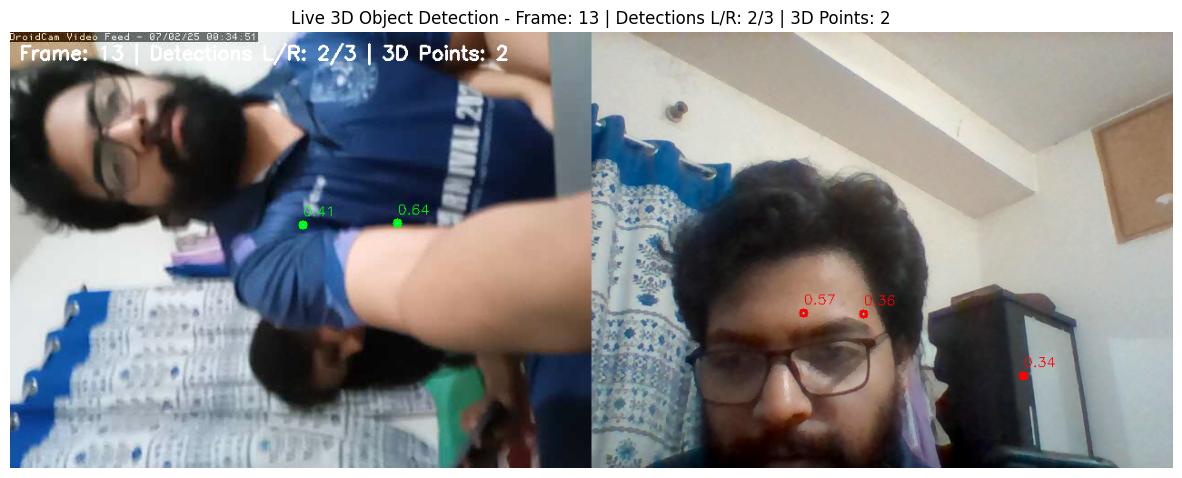

3D Coordinates (X, Y, Z in meters):
  Object 1: X=0.08, Y=0.43, Z=0.02
  Object 2: X=0.00, Y=0.63, Z=0.03
Live detection ended. Processed 13 frames


In [40]:
# 🎥 START LIVE CAMERA FEEDS
# Start live camera feed (uncomment to run)
print("To start live camera feed, run:")
print("show_live_stereo_feed(cap_left, cap_right, duration=10)")
print("\nTo start live 3D detection, run:")
print("live_3d_detection(cap_left, cap_right, duration=15)")

# Option 1: Simple stereo camera view (10 seconds)
# show_live_stereo_feed(cap_left, cap_right, duration=10)

# Option 2: Live object detection with 3D tracking (15 seconds)
live_3d_detection(cap_left, cap_right, duration=15)